## Imports

In [2]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from torchvision import transforms
from tqdm import trange
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", device) # Quick check to see if we're using GPU or CPU.

import optuna
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
from pathlib import Path


# Custom imports
import dataset.download_and_preprocess as dl
from dataset.dataloader import KTHDataset
from autoencoder.autoencoder import AutoencoderModel



import matplotlib.pyplot as plt
from IPython.display import clear_output


Torch device: cuda


## Download the dataset and pre-process the dataset

In [3]:
action_space = ["running"]#['walking', 'running', 'jogging', 'boxing', 'handwaving', 'handclapping']
for action in action_space:
    should_extract = dl.download_and_extract(action, overwrite=False)
    dl.extract_and_save_frames(action, extraction=should_extract)

## Split the data into train, test, validate

In [4]:
image_file_names = []
labels = []

# Uniformly sample a fixed number of files from each action folder
np.random.seed(42)  # For reproducibility
num_samples_per_action = 2500 
for action in action_space:
    folder = Path("dataset") / "KTH_data" / action
    all_files = list(folder.glob("*.pt"))
    sampled_files = np.random.choice(all_files, num_samples_per_action, replace=False)
    image_file_names.extend(sampled_files)
    labels.extend([action] * len(sampled_files))

paths = np.array(image_file_names)
labels = np.array(labels)
paths = files = np.array([torch.load(f) for f in image_file_names])


In [5]:
# Split the dataset into training, validation, and test sets
# 70% training, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    paths, labels, 
    stratify=labels, 
    test_size=0.3, 
    random_state=42
)
# Split the temporary set into validation and test sets
# 50% of the temporary set for validation and 50% for testing (again, 15% each overall)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    stratify=y_temp, 
    test_size=0.5, 
    random_state=42
)


# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(x) if isinstance(x, np.ndarray) else x),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

val_test_transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(x) if isinstance(x, np.ndarray) else x)
])


train_dataset = KTHDataset(X_train, y_train, transform=train_transform)
val_dataset = KTHDataset(X_val, y_val, transform=val_test_transform)
test_dataset = KTHDataset(X_test, y_test, transform=val_test_transform)

# Create sample weights based on training label frequency

# Map class names to integer indices
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(action_space)}
y_train_indices = np.array([class_to_idx[label] for label in y_train])

class_sample_count = np.bincount(y_train_indices)
class_weights = 1. / class_sample_count
sample_weights = class_weights[y_train_indices]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

## Training loop helper functions

In [6]:
def ssim_accuracy_percent(output, target):
    """
    Computes SSIM-based accuracy as a percentage.

    Parameters:
        output (torch.Tensor): Reconstructed images (B, C, H, W), values in [0, 1]
        target (torch.Tensor): Ground truth images (B, C, H, W), values in [0, 1]

    Returns:
        float: SSIM-based accuracy in [0, 100]%
    """

    output_np = output.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()

    ssim_scores = []

    for i in range(output_np.shape[0]):
        out_img = output_np[i, 0]  # Extract 2D image
        tgt_img = target_np[i, 0]
        score = ssim(tgt_img, out_img, data_range=1.0)
        ssim_scores.append(score)

    return 100 * np.mean(ssim_scores)


def plot_model_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs:int, save_path=None, title='fill'):
    """
    Plots training and validation losses and accuracies.

    Parameters:
        train_losses (list): List of training losses.
        val_losses (list): List of validation losses.
        train_accuracies (list): List of training accuracies.
        val_accuracies (list): List of validation accuracies.
        epochs (int): Number of epochs the model trained on (so can be less than 200 due to early-stopping).
        save_path (str): Path to save the plot. If None, the plot will be shown.
        title (str): Title of the plot.
    """
    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(8, 5))
    x = np.arange(1, epochs + 1) # x-axis values (1 to epochs)
    ax2 = ax1.twinx()

    # plot accuracies (solid, left y-axis)
    ax2.plot(x, train_losses, label='Train Loss', color='tab:blue', linestyle='--')
    ax2.plot(x, val_losses, label='Val Loss', color='tab:orange', linestyle='--')
    ax2.set_ylabel('Loss')
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    
    # plot accuracies (solid, right y-axis)
    ax1.plot(x, train_accuracies, label='Train Accuracy', color='tab:blue')
    ax1.plot(x, val_accuracies, label='Val Accuracy', color='tab:orange')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlim(1, epochs+1)

    ax1.set_ylim(30, 100)  # Set y-axis limits for accuracy
    ax1.set_yticks(np.arange(30, 101, 10))  # Set y-ticks for accuracy
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()

    # Legends and title
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
    ax1.set_title(title)

    # Show or save the plot
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close(fig)
    

def train_autoencoder(model, train_loader, val_loader, patience:int = 10, learning_rate:float = 1e-3):
    """
    Training loop for the autoencoder model, which is trained using adam optimizer and MSE loss.
    The training stops if the validation loss does not improve for a specified number of epochs (patience).

    Parameters:
        model (autoencoder.AutoencoderModel): The autoencoder model to be trained. (it has all parameters such as learning rate and epochs)
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        patience (int): Number of epochs with no improvement after which training will be stopped.

    Returns:
        tuple: A tuple containing:
            - train_losses (list): List of training losses.
            - val_losses (list): List of validation losses.
            - train_accuracies (list): List of training accuracies.
            - val_accuracies (list): List of validation accuracies.
    """
    best_val_loss = float("inf")
    epochs_no_improve = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    train_accuracies = []
    train_losses = []

    val_accuracies = []
    val_losses = []

    #for epoch in range(model.epochs):
    for epoch in trange(model.epochs, desc="Epochs"):
        model.trained_epochs += 1
        # Training
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        for images, _ in train_loader:
            images = images.unsqueeze(1).to(device)
            outputs = model(images)
            
            loss = loss_fn(outputs, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            running_accuracy += ssim_accuracy_percent(outputs, images) * images.size(0)


        epoch_accuracy = running_accuracy / len(train_loader.dataset)
        epoch_loss = running_loss / len(train_loader.dataset)
        
        train_accuracies.append(epoch_accuracy)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.unsqueeze(1).to(device)
                outputs = model(images)
                loss = loss_fn(outputs, images)
                val_loss += loss.item() * images.size(0)
                val_accuracy += ssim_accuracy_percent(outputs, images) * images.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        val_accuracy = val_accuracy / len(val_loader.dataset)
        val_accuracies.append(val_accuracy)


        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

        clear_output(True)
        print(f"Loss: {val_loss:5f}\tAccuracy: {val_accuracy:4.1f}")
                
    return train_losses, val_losses, train_accuracies, val_accuracies

## Define optuna optimization function

In [7]:
def optuna_optimization(trial:optuna.Trial):
    """
    Objective function for Optuna optimization.

    Parameters:
        trial (optuna.Trial): Optuna trial object.

    Returns:
        float: Validation loss.
    """
    
    # Define the hyperparameters to optimize
    activation_function = trial.suggest_categorical("activation_function", ["tanh", "relu", "sigmoid", "leaky_relu"])
    

    string_activation_function = {
        "tanh": nn.Tanh(),
        "relu": nn.ReLU(),
        "sigmoid": nn.Sigmoid(),
        "leaky_relu": nn.LeakyReLU()
    }

    af = string_activation_function[activation_function]

    # Initialize the model
    model = AutoencoderModel(epochs=20, a_function=af).to(device)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=256, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_autoencoder(model, train_loader, val_loader, patience=10, learning_rate=1e-3)

    # Determine best metrics for this model
    best_loss = min(val_losses)
    best_accuracy = max(val_accuracies)

    # Save the model
    model.save(filename=f"model_trial_{trial.number}")

    # Save the plot
    save_path = Path("plots") / "autoencoder_training"
    save_path.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist
    save_path = save_path / f"trial_{trial.number}.png"
    plot_model_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model.trained_epochs, save_path=save_path, title=f"Trial {trial.number} - Loss: {best_loss:.4f} - Acc: {best_accuracy:00.1f}")
    

    return best_loss  # Return the minimum validation loss

In [ ]:
study = optuna.create_study(direction="minimize", study_name="Autoencoder Optimization", storage="sqlite:///autoencoder_activationstudy.db", load_if_exists=True)

if not Path("autoencoder_activationstudy.db").exists(): # Lazily skip this.
    study.optimize(optuna_optimization, n_trials=4, n_jobs=1)

studydf = study.trials_dataframe()
studydf

[I 2025-05-30 09:56:45,503] Using an existing study with name 'Autoencoder Optimization' instead of creating a new one.


Best trial params: {'activation_function': 'leaky_relu'}
Best trial loss: 0.004067407455295324
Saved model path: autoencoder\models\model_trial_2.pt


,number,value,datetime_start,datetime_complete,duration,params_activation_function,state
0,0,NaN,2025-05-27 18:57:10.029073,2025-05-27 19:06:59.405817,0 days 00:09:49.376744,tanh,FAIL
1,1,NaN,2025-05-27 19:09:07.732573,2025-05-27 19:16:33.356014,0 days 00:07:25.623441,tanh,FAIL
2,2,0.004067,2025-05-27 19:16:50.046234,2025-05-27 19:29:41.767403,0 days 00:12:51.721169,leaky_relu,COMPLETE
3,3,0.040412,2025-05-27 19:29:41.788679,2025-05-27 19:44:37.611361,0 days 00:14:55.822682,sigmoid,COMPLETE
4,4,0.004162,2025-05-27 19:44:37.629156,2025-05-27 19:59:28.484566,0 days 00:14:50.855410,relu,COMPLETE
5,5,0.035693,2025-05-27 19:59:28.500829,2025-05-27 20:12:17.286296,0 days 00:12:48.785467,tanh,COMPLETE
6,6,0.037551,2025-05-28 09:13:21.687156,2025-05-28 09:20:52.440841,0 days 00:07:30.753685,tanh,COMPLETE
7,7,NaN,2025-05-28 09:20:52.461881,2025-05-28 09:24:56.942537,0 days 00:04:04.480656,sigmoid,FAIL
8,8,NaN,2025-05-28 09:25:27.179450,2025-05-28 09:26:17.611347,0 days 00:00:50.431897,relu,FAIL
9,9,NaN,2025-05-30 09:55:22.620617,2025-05-30 09:55:35.692118,0 days 00:00:13.071501,tanh,FAIL


### Fully train a 100-latent space model

In [9]:
model_path = Path("autoencoder") / "models" / "model.pt"


batch_size = 256
learning_rate = 1e-3

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

if not model_path.exists():
    
    model = AutoencoderModel(latent_dim=100, epochs=200, a_function=nn.LeakyReLU()).to(device)

    # Train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_autoencoder(model, train_loader, val_loader, patience=10, learning_rate=learning_rate)

    # Determine best metrics for this model
    best_loss = min(val_losses)
    best_accuracy = max(val_accuracies)

    # Save the mode
    model.save(filename=f"model")

    # Save the plot
    save_path = Path("plots") / "autoencoder_training"
    save_path.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist
    save_path = save_path / f"model.png"
    plot_model_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model.trained_epochs, save_path=save_path, title=f"Custom trial - Loss: {best_loss:.4f} - Acc: {best_accuracy:00.1f}")



### Load our trained models

In [11]:
model = AutoencoderModel(latent_dim=100, epochs=200, a_function=nn.LeakyReLU()).to(device)
model.load(model_path)


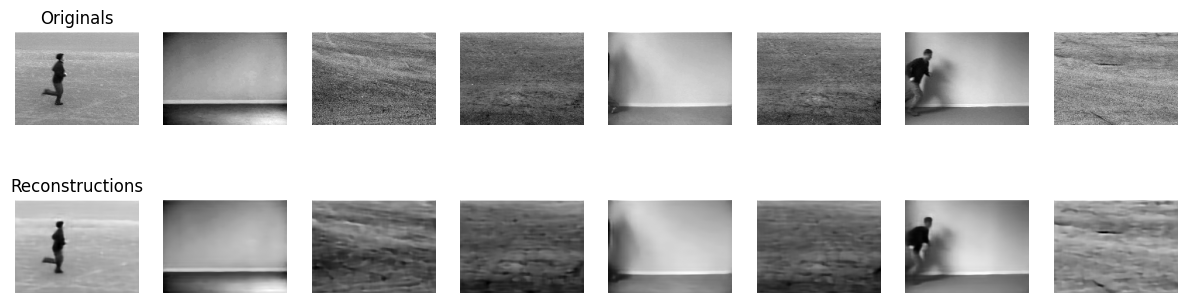

In [12]:
import random

model.eval()
with torch.no_grad():
    # Grab 8 random indices from the test set
    indices = random.sample(range(len(test_dataset)), 8)
    sample_imgs = torch.stack([test_dataset[i][0] for i in indices])
    sample_imgs = sample_imgs.unsqueeze(1).to(device)
    reconstructions = model(sample_imgs)

fig, axs = plt.subplots(2, 8, figsize=(15, 4))
for i in range(8):
    axs[0, i].imshow(sample_imgs[i, 0].cpu(), cmap='gray')
    axs[1, i].imshow(reconstructions[i, 0].cpu(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
axs[0, 0].set_title("Originals")
axs[1, 0].set_title("Reconstructions")
plt.show()


### Reconstruct a video

In [ ]:
query_video = "person01_running_d1"
video_location = Path("dataset") / "KTH_data" / "running"
video_frames = len(list(video_location.glob(f"{query_video}_frame_*.pt")))

original_frames = []
processed_frames = []

model.eval()

for frame in range(1, video_frames):
    file = torch.load(video_location / f"{query_video}_frame_{frame}.pt")
    original_np = file.cpu().numpy()

    # Run through model
    with torch.no_grad():
        reconstructed = model(file.unsqueeze(0).unsqueeze(0).to(device))
        reconstructed_np = reconstructed.squeeze().cpu().numpy()

    # Append both frames
    original_frames.append(original_np)
    processed_frames.append(reconstructed_np)

# Convert lists to arrays
original_frames = np.array(original_frames)
processed_frames = np.array(processed_frames)

# Normalize if not in [0,1]
original_frames = np.clip(original_frames, 0, 1)
processed_frames = np.clip(processed_frames, 0, 1)

# Add 5-pixel separator
separator = np.zeros((len(original_frames), 120, 5), dtype=np.float32)
combined_frames = np.concatenate((original_frames, separator, processed_frames), axis=2)

# Convert to uint8 for video
combined_uint8 = (combined_frames * 255).astype(np.uint8)

# Convert grayscale to 3-channel
combined_bgr = np.stack([combined_uint8]*3, axis=-1)  # Shape: (N, H, W, 3)

# Setup video writer
output_path = f"{query_video}_combined_reconstruction.mp4"
height, width = combined_bgr.shape[1:3]
fps = 25
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=True)

for frame in combined_bgr:
    video_writer.write(frame)

video_writer.release()